# Convolutional Neural Network with CIFAR-10
이번 실습에서는 CIFAR-10 dataset을 이용하여 CNN을 학습해보겠습니다.


In [1]:
## Google Colab에서 TensorFlow 2.x 버전을 사용하기 위해서는 아래 magic command를 수행하면 간편하게 할 수 있습니다

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
## 필요한 Library들을 import 합니다
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## TensorFlow, Keras version 확인
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


In [0]:
np.random.seed(777)
tf.random.set_seed(777)

## Coding Tips

#### 1. Hyper Paramter 정하기
#### 2. Data 준비(불러오기 or download 등)
#### 3. Dataset 구성 (tf.data.Dataset 이용)
#### 4. Modlel 만들기 (Neural Network model)
#### 5. Loss function 정의, Optimizer 선택
#### 6. Training (Train, Test function 만들기 포함)
#### 7. Validation(or Test) 결과 확인

In [0]:
## Hyper-parameters
learning_rate = 0.001
N_EPOCHS = 20
N_BATCH = 100
N_CLASS = 10

In [0]:
## Cifar10 Dataset #########################################################
cifar = keras.datasets.cifar10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
############################################################################

In [0]:
## MNIST dataset load
(train_images, train_labels), (test_images, test_labels) = cifar.load_data() 

In [7]:
## train_images, train_labels의 shape 확인
train_images.shape, train_labels.shape

((50000, 32, 32, 3), (50000, 1))

In [8]:
## test_images, test_labels의 shape 확인
test_images.shape, test_labels.shape

((10000, 32, 32, 3), (10000, 1))

In [9]:
## training set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(train_labels, (50000,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

In [10]:
## test set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(test_labels, (10000,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 1000,
 1: 1000,
 2: 1000,
 3: 1000,
 4: 1000,
 5: 1000,
 6: 1000,
 7: 1000,
 8: 1000,
 9: 1000}

In [0]:
N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]

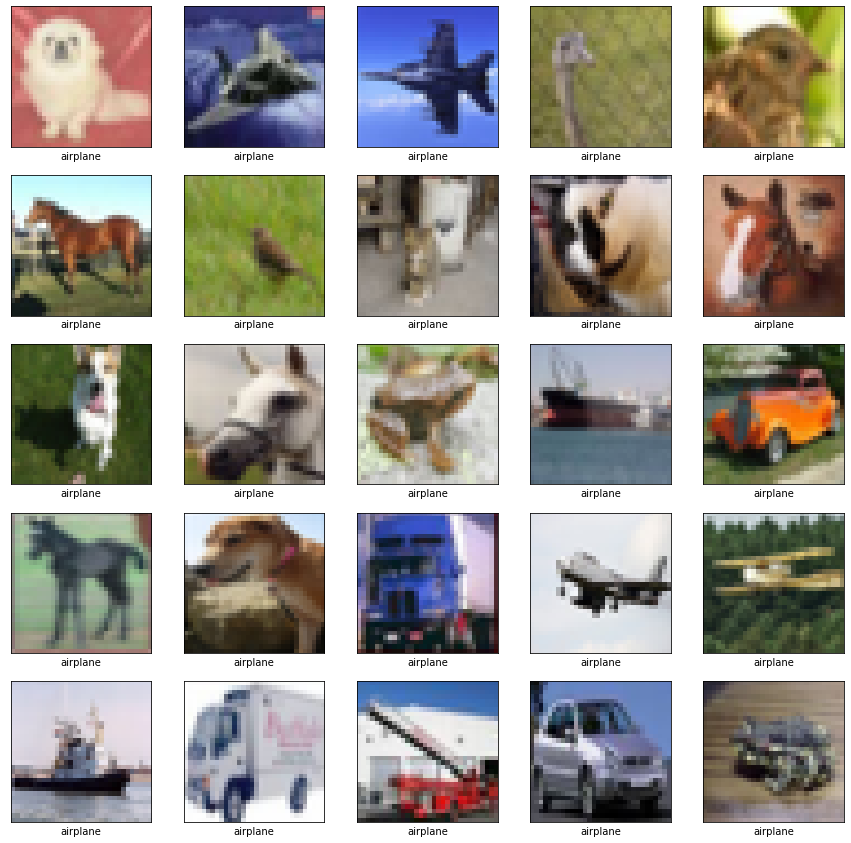

In [12]:
## Data 확인
plt.figure(figsize=(15,15))
for i in range(25):
    img_idx = np.random.randint(0, 49999)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx])
    plt.xlabel(class_names[np.argmax(train_labels[img_idx])])

In [0]:
# pixel값을 0~1사이 범위로 조정
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

# label을 onehot-encoding
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

In [14]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


In [0]:
## dataset 구성    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=50000).batch(N_BATCH).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(N_BATCH)

In [0]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(32, 32, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [17]:
## Create model, compile & summary
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [18]:
## Parameters for training
steps_per_epoch = N_TRAIN//N_BATCH
validation_steps = N_TEST//N_BATCH
print(steps_per_epoch, validation_steps)

500 100


In [19]:
## Training
history = model.fit(train_dataset, epochs=N_EPOCHS, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 500 steps, validate for 100 steps
Epoch 1/20
500/500 [==============================] - 8s 15ms/step - loss: 1.5963 - accuracy: 0.4173 - val_loss: 1.2278 - val_accuracy: 0.5588
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 1.1794 - accuracy: 0.5820 - val_loss: 1.0359 - val_accuracy: 0.6282
Epoch 3/20
500/500 [==============================] - 5s 9ms/step - loss: 0.9989 - accuracy: 0.6523 - val_loss: 0.9390 - val_accuracy: 0.6653
Epoch 4/20
500/500 [==============================] - 5s 9ms/step - loss: 0.8732 - accuracy: 0.6937 - val_loss: 0.8660 - val_accuracy: 0.6999
Epoch 5/20
500/500 [==============================] - 5s 9ms/step - loss: 0.7811 - accuracy: 0.7259 - val_loss: 0.7829 - val_accuracy: 0.7276
Epoch 6/20
500/500 [==============================] - 5s 9ms/step - loss: 0.7016 - accuracy: 0.7545 - val_loss: 0.7494 - val_accuracy: 0.7405
Epoch 7/20
500/500 [==============================] - 5s 10ms/step - loss: 0.6419 - accuracy: 0.7752 -

In [0]:
## 결과 확인
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(N_CLASS), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(N_CLASS), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

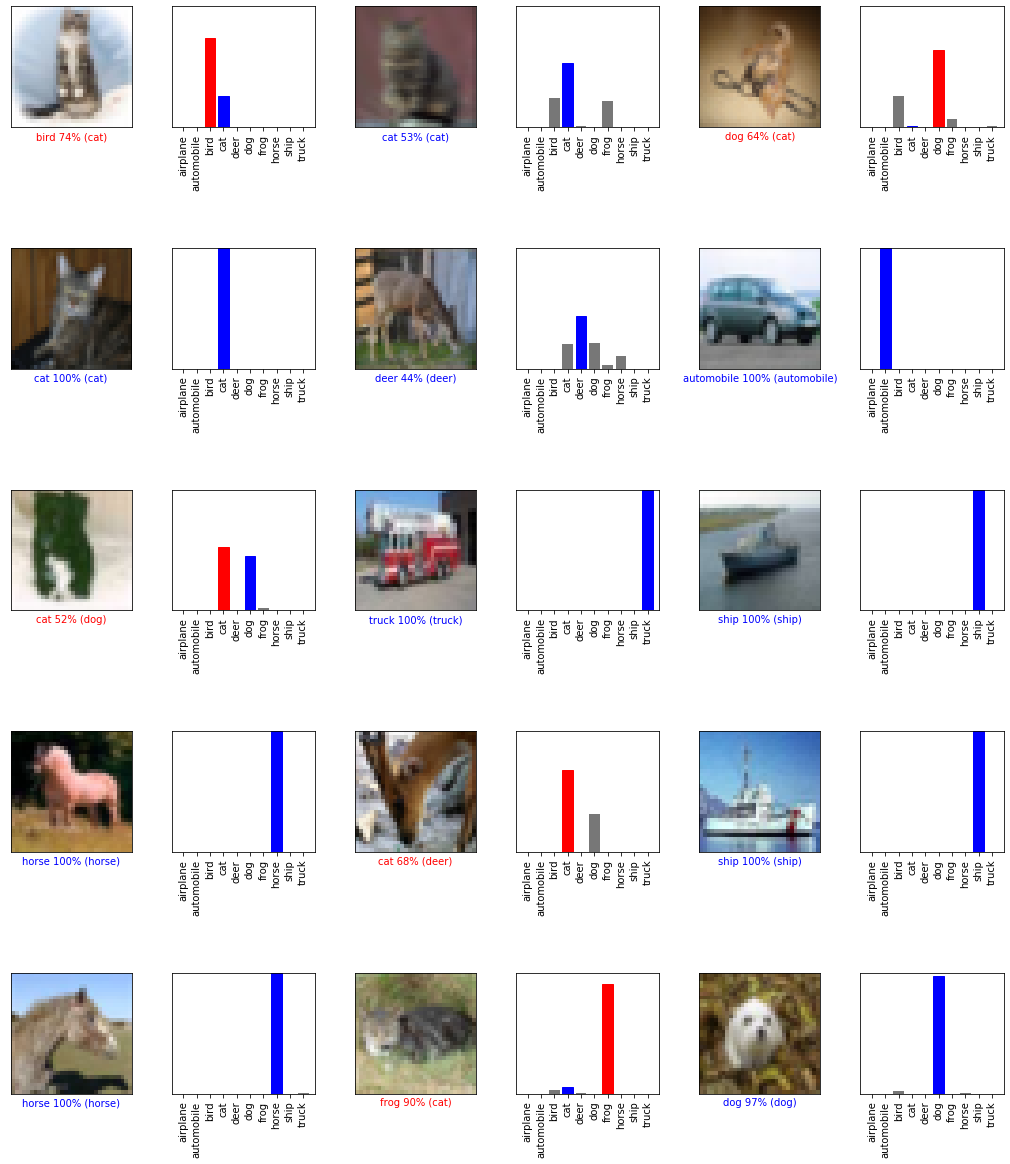

In [21]:
rnd_idx = np.random.randint(1, N_TEST//N_BATCH)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break